In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import sys
import warnings
import time
from typing import Tuple, List
import pickle

import gpflow
from gpflow.utilities import ops, print_summary
from gpflow.config import set_default_float, default_float, set_default_summary_fmt, default_jitter
from gpflow.ci_utils import ci_niter
from gpflow.models import gplvm
from gpflow.optimizers import NaturalGradient
from gpflow import covariances, set_trainable
from gpflow.models.util import inducingpoint_wrapper

from split_gplvm import SplitGPLVM
from test_gplvm import TestGPLVM
from utils import *

In [4]:
data = pd.read_csv('../data/3PhData/DataTrn.txt', sep='  ', header=None, engine='python')
labels_dummy = pd.read_csv('../data/3PhData/DataTrnLbls.txt', sep='  ', header=None, engine='python')

In [5]:
# subsample to smaller size
data = data.sample(100, random_state=1).sort_index()
labels_dummy = labels_dummy.loc[data.index, :]

In [6]:
labels = labels_dummy.apply(lambda x: np.where(x == 1)[0][0] + 1, axis=1).values
Y = tf.convert_to_tensor(data, dtype=default_float())
labels = tf.convert_to_tensor(labels)

### Bayesian GPLVM

In [56]:
# reproduce the settings in Titsias 2009

np.random.seed(2)  # for reproducibility

latent_dim = 10  # number of latent dimensions
num_inducing = 20  # number of inducing pts
num_data = Y.shape[0]  # number of data points

X_mean_init = ops.pca_reduce(Y, latent_dim)
X_var_init = tf.ones((num_data, latent_dim), dtype=default_float()) * 0.5

inducing_variable = tf.convert_to_tensor(
    np.random.permutation(X_mean_init.numpy())[:num_inducing], dtype=default_float()
)

lengthscales = tf.convert_to_tensor([1.0] * latent_dim, dtype=default_float())
kernel = gpflow.kernels.SquaredExponential(lengthscales=lengthscales)

bgplvm = gpflow.models.BayesianGPLVM(
    Y,
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    kernel=kernel,
    inducing_variable=inducing_variable,
)

bgplvm.likelihood.variance.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-4.600266525158521>

In [57]:
bgplvm.elbo()

<tf.Tensor: shape=(), dtype=float64, numpy=-74283.68958941477>

#### Using Scipy optimizer

In [58]:
%%time
opt = gpflow.optimizers.Scipy()
maxiter = ci_niter(1000)
_ = opt.minimize(
    bgplvm.training_loss,
    method="BFGS",
    variables=bgplvm.trainable_variables,
    options=dict(maxiter=maxiter, disp=True),
)

         Current function value: 27.932027
         Iterations: 770
         Function evaluations: 791
         Gradient evaluations: 780
CPU times: user 15min, sys: 48.4 s, total: 15min 48s
Wall time: 8min 26s


In [59]:
bgplvm

name,class,transform,prior,trainable,shape,dtype,value
BayesianGPLVM.kernel.variance,Parameter,Softplus,,True,(),float64,1.3769832716376151
BayesianGPLVM.kernel.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[6.13354538e+07, 7.45038258e+07, 7.31691767e+07..."
BayesianGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.010635517838846673
BayesianGPLVM.X_data_mean,Parameter,,,True,"(100, 10)",float64,"[[-9.97553928e-07, 1.04762988e-06, -7.96825987e-07..."
BayesianGPLVM.X_data_var,Parameter,Softplus,,True,"(100, 10)",float64,"[[9.99878898e-01, 9.99984443e-01, 9.99939017e-01..."
BayesianGPLVM.inducing_variable.Z,Parameter,,,True,"(20, 10)",float64,"[[6.27954442e+07, 4.64063301e+07, 6.31032845e+07..."


M = 20

<BarContainer object of 10 artists>

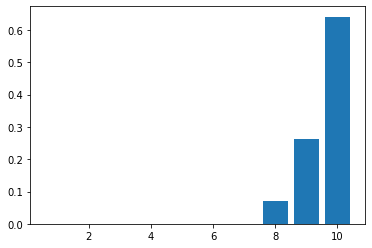

In [60]:
plt.bar(np.linspace(1, 10, 10, dtype=int), 1 / bgplvm.kernel.lengthscales.numpy())

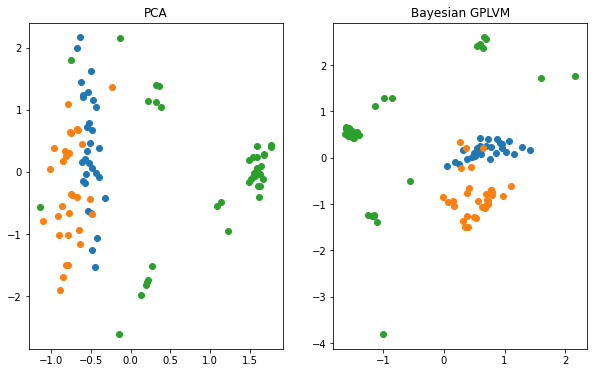

In [61]:
X_pca = ops.pca_reduce(Y, 2).numpy()
gplvm_X_mean = bgplvm.X_data_mean.numpy()
top_idx = np.argsort(1 / bgplvm.kernel.lengthscales.numpy())[-2:]

f, ax = plt.subplots(1, 2, figsize=(10, 6))

for i in np.unique(labels):
    ax[0].scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], label=i)
    ax[1].scatter(gplvm_X_mean[labels == i, top_idx[-1]], gplvm_X_mean[labels == i, top_idx[-2]], label=i)
    ax[0].set_title("PCA")
    ax[1].set_title("Bayesian GPLVM")

M = 50

<BarContainer object of 10 artists>

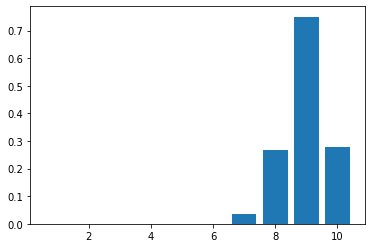

In [236]:
plt.bar(np.linspace(1, 10, 10, dtype=int), 1 / bgplvm.kernel.lengthscales.numpy())

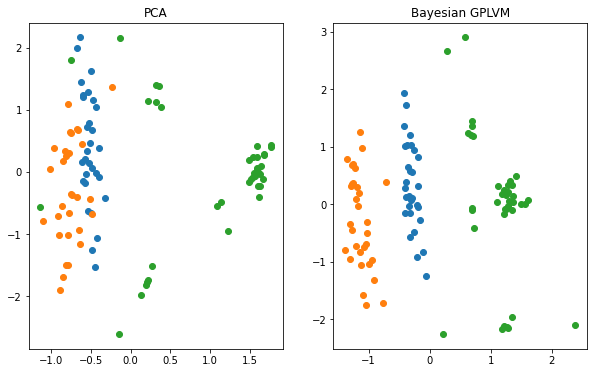

In [237]:
X_pca = ops.pca_reduce(Y, 2).numpy()
gplvm_X_mean = bgplvm.X_data_mean.numpy()
top_idx = np.argsort(1 / bgplvm.kernel.lengthscales.numpy())[-2:]

f, ax = plt.subplots(1, 2, figsize=(10, 6))

for i in np.unique(labels):
    ax[0].scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], label=i)
    ax[1].scatter(gplvm_X_mean[labels == i, top_idx[-1]], gplvm_X_mean[labels == i, top_idx[-2]], label=i)
    ax[0].set_title("PCA")
    ax[1].set_title("Bayesian GPLVM")

#### Using Adam

In [414]:
%%time
@tf.function
def optimization_step(model: gpflow.models.BayesianGPLVM):
    adam_opt.minimize(model.training_loss, var_list=model.trainable_variables)
    elbo = model.elbo()
    return elbo

adam_opt = tf.optimizers.Adam(learning_rate=0.01)

logf = []
tol = 1e-4
log_freq = 100
num_iterations = 30000

tf.print('initial elbo {:.4f}'.format(bgplvm.elbo()))

for step in range(num_iterations):
    start_time = time.time()
    elbo = optimization_step(bgplvm)
    logf.append(elbo)
    if step > 0 and np.abs(elbo - logf[-2]) < tol:
        tf.print('converge at iteration {} elbo {:.4f}'.format(step+1, elbo))
        break
    if (step + 1)  % log_freq == 0:
        tf.print('iteration {} elbo {:.4f}, took {:.4f}s'.format(step+1, elbo, time.time()-start_time))

initial elbo -69656.4498
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function optimization_step at 0x1532b80d0>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function optimization_step at 0x1532b80d0>. Note that functions defined in certain environments, li

iteration 15200 elbo 59.9929, took 0.0106s
iteration 15300 elbo 61.7117, took 0.0212s
iteration 15400 elbo 63.3939, took 0.0129s
iteration 15500 elbo 65.0471, took 0.0119s
iteration 15600 elbo 66.6753, took 0.0118s
iteration 15700 elbo 68.2716, took 0.0125s
iteration 15800 elbo 69.8392, took 0.0118s
iteration 15900 elbo 71.3789, took 0.0113s
iteration 16000 elbo 72.8872, took 0.0125s
iteration 16100 elbo 74.3752, took 0.0114s
iteration 16200 elbo 75.8328, took 0.0123s
iteration 16300 elbo 77.2642, took 0.0116s
iteration 16400 elbo 78.6709, took 0.0124s
iteration 16500 elbo 80.0548, took 0.0129s
iteration 16600 elbo 81.4103, took 0.0142s
iteration 16700 elbo 82.7457, took 0.0125s
iteration 16800 elbo 84.0569, took 0.0113s
iteration 16900 elbo 85.3433, took 0.0111s
iteration 17000 elbo 86.6092, took 0.0124s
iteration 17100 elbo 87.8515, took 0.0110s
iteration 17200 elbo 89.0670, took 0.0110s
iteration 17300 elbo 90.2694, took 0.0121s
iteration 17400 elbo 91.4437, took 0.0123s
iteration 1

In [415]:
bgplvm

name,class,transform,prior,trainable,shape,dtype,value
BayesianGPLVM.kernel.variance,Parameter,Softplus,,True,(),float64,0.466081762373777
BayesianGPLVM.kernel.lengthscales,Parameter,Softplus,,True,"(10,)",float64,"[159.21111685, 159.41539459, 158.63231026..."
BayesianGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0030002928723618988
BayesianGPLVM.X_data_mean,Parameter,,,True,"(100, 10)",float64,"[[-8.25542968e-05, 1.13255943e-04, 1.55291729e-04..."
BayesianGPLVM.X_data_var,Parameter,Softplus,,True,"(100, 10)",float64,"[[9.32697335e-01, 9.32847468e-01, 9.32254394e-01..."
BayesianGPLVM.inducing_variable.Z,Parameter,,,True,"(50, 10)",float64,"[[-8.13748083e-03, 3.37685229e-02, -8.85990811e-05..."


<BarContainer object of 10 artists>

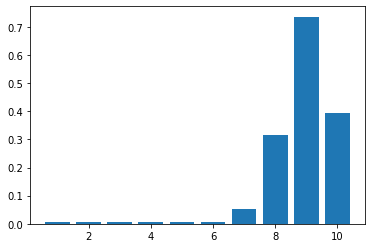

In [416]:
plt.bar(np.linspace(1, 10, 10, dtype=int), 1 / bgplvm.kernel.lengthscales.numpy())

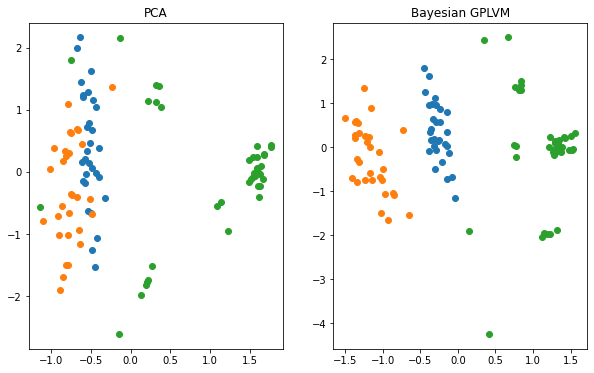

In [417]:
X_pca = ops.pca_reduce(Y, 2).numpy()
gplvm_X_mean = bgplvm.X_data_mean.numpy()
top_idx = np.argsort(1 / bgplvm.kernel.lengthscales.numpy())[-2:]

f, ax = plt.subplots(1, 2, figsize=(10, 6))

for i in np.unique(labels):
    ax[0].scatter(X_pca[labels == i, 0], X_pca[labels == i, 1], label=i)
    ax[1].scatter(gplvm_X_mean[labels == i, top_idx[-1]], gplvm_X_mean[labels == i, top_idx[-2]], label=i)
    ax[0].set_title("PCA")
    ax[1].set_title("Bayesian GPLVM")

#### Current result on Bayesian GPLVM
* Setting
    * D = 10, M = 50, X_mean initialized w/ PCA, Zs are randomly sampled
* Scipy optimizer works (12mins, elbo=-174, num iter=861): initial loss -69656
    * Scipy optimization sometimes fails because cholesky of Kuu fails b/c Kuu is not invertible, probably because as the model gets optimized, some inducing points becomes too close to each other
* Adam also gives reasonable result (6mins, 30000 iter haven't converged, elbo=157)

### Test GPLVM
Exact implementation of Bayesian GPLVM. Used to debug my code

In [6]:
# reproduce the settings in Titsias 2009

np.random.seed(2)  # for reproducibility

latent_dim = 10  # number of latent dimensions
num_inducing = 20  # number of inducing pts
num_data = Y.shape[0]  # number of data points

X_mean_init = ops.pca_reduce(Y, latent_dim)
X_var_init = tf.ones((num_data, latent_dim), dtype=default_float()) * 0.5

inducing_variable = tf.convert_to_tensor(
    np.random.permutation(X_mean_init.numpy())[:num_inducing], dtype=default_float()
)

k1 = gpflow.kernels.SquaredExponential(lengthscales=[1.0] * 5, active_dims=[0, 1, 2, 3, 4])
k2 = gpflow.kernels.SquaredExponential(lengthscales=[1.0] * 5, active_dims=[5, 6, 7, 8, 9])
kernel = k1 + k2

test_gplvm = TestGPLVM(
    Y,
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    kernel=kernel,
    inducing_variable=inducing_variable,
)

test_gplvm.likelihood.variance.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-4.600266525158521>

In [7]:
%%time
opt = gpflow.optimizers.Scipy()
maxiter = ci_niter(1000)
_ = opt.minimize(
    test_gplvm.training_loss,
    method="BFGS",
    variables=test_gplvm.trainable_variables,
    options=dict(maxiter=maxiter, disp=True),
)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
         Current function value: -104.955471
         Iterations: 422
         Function evaluations: 458
         Gradient evaluations: 446
CPU times: user 8min 15s, sys: 25.2 s, total: 8min 41s
Wall time: 4min 32s


#### Experiment 1
* Setting
    * k1 deals with (1:5) dim, k2 (6:10), k = k1 + k2
    * Z = 50, D = 10
* Result
    * Scipy optimizer, converge at ELBO=180 around 7mins
    * We are overfitting in the first 5 dimensions: all lengthscales are extremely small i.e. inverse lengthscales are extremely large (see below), so on each dimension the function is super wiggly, i.e. overfitting to the locations of each point
    * In the last 5 dimensions though, it appears fine, and the two dimensions with the largest inverse show nice seperations 

In [193]:
test_gplvm

name,class,transform,prior,trainable,shape,dtype,value
TestGPLVM.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,3.9556915033003266e-08
TestGPLVM.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[4.84534265e-16, 6.64351675e-38, 7.31009678e-05..."
TestGPLVM.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.7364122472014499
TestGPLVM.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[571.61150055, 26.29390144, 3.34295296..."
TestGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.002854672940925118
TestGPLVM.X_data_mean,Parameter,,,True,"(100, 10)",float64,"[[-2.35524207e-05, -3.95412836e-05, -1.34762312e-06..."
TestGPLVM.X_data_var,Parameter,Softplus,,True,"(100, 10)",float64,"[[9.99753570e-01, 9.99661271e-01, 9.99741324e-01..."
TestGPLVM.inducing_variable.Z,Parameter,,,True,"(50, 10)",float64,"[[4.16409760e+00, -4.07662219e+01, 3.52485819e+01..."


In [249]:
test_gplvm.kernel.kernels[0].lengthscales

<gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=(5,) unconstrained-value=[ -35.26334352  -85.60459208   -9.5236324   -52.45039755 -173.24631694] constrained-shape=(5,) constrained-value=[4.84534265e-16 6.64351675e-38 7.31009678e-05 1.66372587e-23
 5.75546664e-76]>

Text(0, 0.5, 'inverse lengthscale')

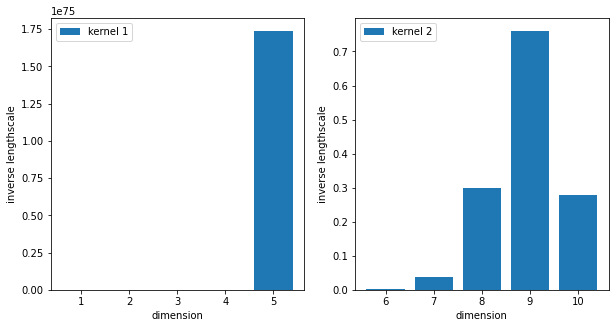

In [242]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 
axs = axs.flatten()

axs[0].bar(np.arange(1, 6), 1 / test_gplvm.kernel.kernels[0].lengthscales.numpy(), label='kernel 1')
axs[0].legend()
axs[0].set_xlabel('dimension')
axs[0].set_ylabel('inverse lengthscale')

axs[1].bar(np.arange(6, 11), 1 / test_gplvm.kernel.kernels[1].lengthscales.numpy(), label='kernel 2')
axs[1].legend()
axs[1].set_xlabel('dimension')
axs[1].set_ylabel('inverse lengthscale')

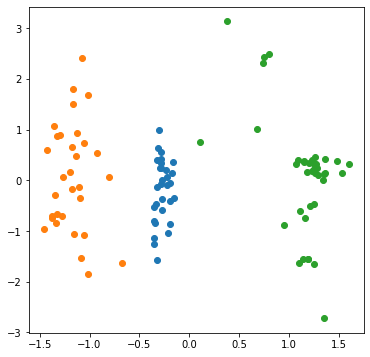

In [201]:
test_X_mean = test_gplvm.X_data_mean.numpy()

plt.figure(figsize=(6, 6))

for i in np.unique(labels):
    plt.scatter(test_X_mean[labels == i, 8], test_X_mean[labels == i, 7], label=i)

#### Experiment 2
* Setting
    * Same as Exp 1, except M = 20
* Result
    * Converges at ELBO = -104, 4 mins
    * Same overfitting problem as Exp 1, less clear separation but still decent

In [8]:
test_gplvm

name,class,transform,prior,trainable,shape,dtype,value
TestGPLVM.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,6.756189860452263e-47
TestGPLVM.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[3.00814795e-30, 9.21436531e-13, 1.43225271e-42..."
TestGPLVM.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.421859411534228
TestGPLVM.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[284.50578737, 22.60906808, 4.86421807..."
TestGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.004433872560883006
TestGPLVM.X_data_mean,Parameter,,,True,"(100, 10)",float64,"[[-8.44460374e-05, -2.66687669e-05, 1.29481708e-04..."
TestGPLVM.X_data_var,Parameter,Softplus,,True,"(100, 10)",float64,"[[1.00296106e+00, 1.00349413e+00, 1.00307538e+00..."
TestGPLVM.inducing_variable.Z,Parameter,,,True,"(20, 10)",float64,"[[2.89635071e+01, 2.81039334e+01, 3.87516816e+01..."


In [17]:
test_gplvm.kernel.kernels[0].lengthscales.numpy()

array([3.00814795e-30, 9.21436531e-13, 1.43225271e-42, 8.29122620e-26,
       6.17990579e-56])

Text(0, 0.5, 'inverse lengthscale')

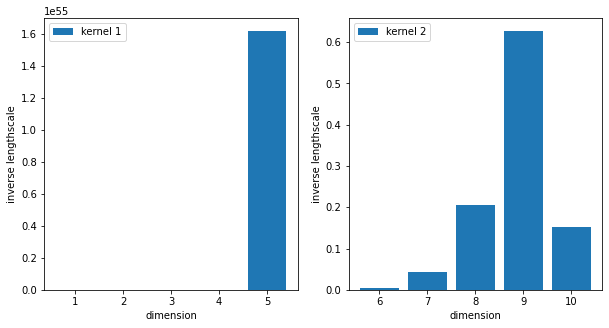

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 
axs = axs.flatten()

axs[0].bar(np.arange(1, 6), 1 / test_gplvm.kernel.kernels[0].lengthscales.numpy(), label='kernel 1')
axs[0].legend()
axs[0].set_xlabel('dimension')
axs[0].set_ylabel('inverse lengthscale')

axs[1].bar(np.arange(6, 11), 1 / test_gplvm.kernel.kernels[1].lengthscales.numpy(), label='kernel 2')
axs[1].legend()
axs[1].set_xlabel('dimension')
axs[1].set_ylabel('inverse lengthscale')

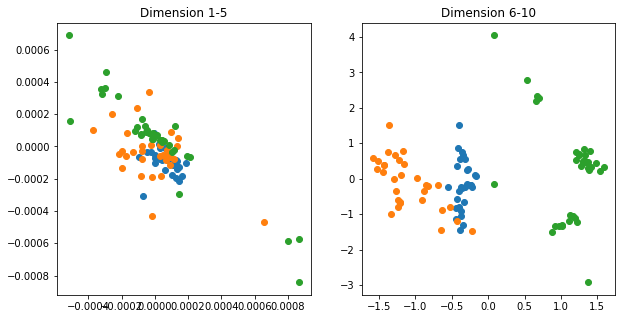

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

test_X_mean = test_gplvm.X_data_mean.numpy()
top_idx1 = np.argsort(test_gplvm.kernel.kernels[0].lengthscales.numpy())
top_idx2 = np.argsort(test_gplvm.kernel.kernels[1].lengthscales.numpy()) + 5

for i in np.unique(labels):
    axs[0].scatter(test_X_mean[labels == i, top_idx1[0]], test_X_mean[labels == i, top_idx1[1]], label=i)
    axs[0].set_title("Dimension 1-5")
    axs[1].scatter(test_X_mean[labels == i, top_idx2[0]], test_X_mean[labels == i, top_idx2[1]], label=i)
    axs[1].set_title("Dimension 6-10")

### Split-GPLVM

In [14]:
np.random.seed(1)

m1 = init_split_gplvm(
    Y,
    split_space=True,
    Qs=5,
    Qp=5,
    M=20,
    K=1
)

m2 = init_split_gplvm(
    Y,
    split_space=True,
    Qs=5,
    Qp=5,
    M=20,
    K=3
)

In [22]:
m3 = init_split_gplvm(
    Y,
    split_space=True,
    Qs=5,
    Qp=5,
    M=20,
    K=1
)

In [17]:
%%time
train_scipy(m1, 2000, True)

step 0 elbo: -2549.9462574357785
step 1 elbo: -2063.441398085919
step 2 elbo: -2007.3995197514496
step 3 elbo: -1917.3254982904093
step 4 elbo: -1764.778250460791
step 5 elbo: -1123.542490508051
step 6 elbo: -1076.9854937373982
step 7 elbo: -1059.2126753424993
step 8 elbo: -1032.2693060714182
step 9 elbo: -1018.7576017367883
step 10 elbo: -1009.9159363348679
step 11 elbo: -1006.2971133223233
step 12 elbo: -1002.1324760359726
step 13 elbo: -1000.967435005824
step 14 elbo: -999.837535194224
step 15 elbo: -998.4583756912087
step 16 elbo: -996.833198811009
step 17 elbo: -994.7263998502407
step 18 elbo: -992.4733169742162
step 19 elbo: -990.7907266733184
step 20 elbo: -989.6754780276422
step 21 elbo: -988.0171605895144
step 22 elbo: -986.3850726034618
step 23 elbo: -984.4556401680557
step 24 elbo: -983.5115679034151
step 25 elbo: -981.9410298916704
step 26 elbo: -979.7895465670356
step 27 elbo: -977.3611313895233
step 28 elbo: -975.8746119809892
step 29 elbo: -974.4050136053282
step 30 elbo

KeyboardInterrupt: 

In [18]:
m1

name,class,transform,prior,trainable,shape,dtype,value
SplitGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.11601661655180003
SplitGPLVM.kernel_K[0].variance,Parameter,Softplus,,True,(),float64,0.008087081135057147
SplitGPLVM.kernel_K[0].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[0.004594, 0.1102806, 0.03418879..."
SplitGPLVM.Xp_mean,Parameter,,,True,"(100, 5)",float64,"[[-2.14008771e-04, 4.05433019e-04, -5.35529865e-04..."
SplitGPLVM.Xp_var,Parameter,Softplus,,True,"(100, 5)",float64,"[[0.99999241, 1.00004385, 0.99994109..."
SplitGPLVM.pi,Parameter,SoftmaxCentered,,True,"(100, 1)",float64,[[1....
SplitGPLVM.Zp.Z,Parameter,,,True,"(20, 5)",float64,"[[8.61294575e-01, -9.08636023e-01, -1.73378129e-01..."
SplitGPLVM.q_mu,Parameter,,,True,"(20, 12)",float64,"[[-1.62427457e-02, -2.99472596e-03, -6.94398035e-03..."
SplitGPLVM.q_sqrt,Parameter,FillTriangular,,True,"(12, 20, 20)",float64,"[[[6.74625464e-01, 0.00000000e+00, 0.00000000e+00..."
SplitGPLVM.kernel_s.variance,Parameter,Softplus,,True,(),float64,0.01882121129649835


In [23]:
%%time
log3, _ = train_natgrad_adam(m3, 2000, 10)

initial elbo -3273.3255
iteration 10 elbo -2801.1983, took 0.0262s
iteration 20 elbo -2620.4050, took 0.0491s
iteration 30 elbo -2480.5554, took 0.0253s
iteration 40 elbo -2368.8989, took 0.0283s
iteration 50 elbo -2277.3641, took 0.0240s
iteration 60 elbo -2203.5441, took 0.0229s
iteration 70 elbo -2143.8085, took 0.0258s
iteration 80 elbo -2094.2826, took 0.0245s
iteration 90 elbo -2052.1939, took 0.0227s
iteration 100 elbo -2015.4343, took 0.0228s
iteration 110 elbo -1982.6337, took 0.0240s
iteration 120 elbo -1952.9435, took 0.0243s
iteration 130 elbo -1925.7406, took 0.0246s
iteration 140 elbo -1900.4897, took 0.0249s
iteration 150 elbo -1876.7351, took 0.0256s
iteration 160 elbo -1854.0975, took 0.0250s
iteration 170 elbo -1832.2715, took 0.0258s
iteration 180 elbo -1811.0227, took 0.0284s
iteration 190 elbo -1790.1825, took 0.0267s
iteration 200 elbo -1769.6319, took 0.0282s
iteration 210 elbo -1749.2664, took 0.0289s
iteration 220 elbo -1728.9717, took 0.0405s
iteration 230 elb

iteration 1880 elbo -737.2820, took 0.0239s
iteration 1890 elbo -737.2644, took 0.0235s
iteration 1900 elbo -737.2471, took 0.0244s
iteration 1910 elbo -737.2302, took 0.0241s
iteration 1920 elbo -737.2136, took 0.0270s
iteration 1930 elbo -737.1972, took 0.0264s
iteration 1940 elbo -737.1812, took 0.0267s
iteration 1950 elbo -737.1654, took 0.0252s
iteration 1960 elbo -737.1500, took 0.0243s
iteration 1970 elbo -737.1347, took 0.0252s
iteration 1980 elbo -737.1198, took 0.0241s
iteration 1990 elbo -737.1051, took 0.0273s
iteration 2000 elbo -737.0907, took 0.0237s
CPU times: user 2min 8s, sys: 43.9 s, total: 2min 52s
Wall time: 1min 8s


## 09/15

### Test if there is an optimizer issue
* m1 is optimized w/ scipy (all parameters are trainable), killed b/c too slow
* m3 is optimized w/ natgrad + adam (natgrad learns q_mu and q_sqrt)
* Both have M = 20, K = 1, Qs=Qp=5
* Doesn't seem so, elbo and embeddings look similar

Text(0, 0.5, 'inverse lengthscale')

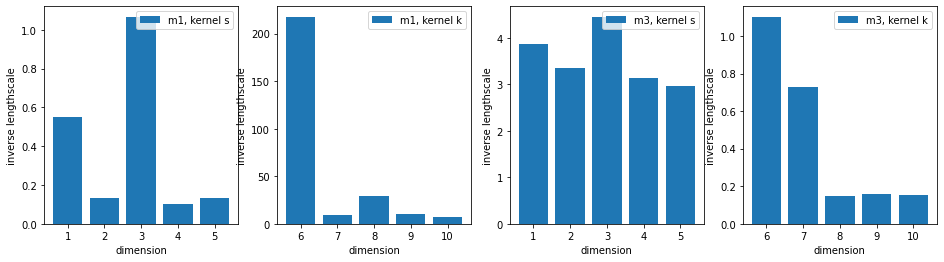

In [27]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4)) 
axs = axs.flatten()

axs[0].bar(np.arange(1, 6), 1 / m1.kernel_s.lengthscales.numpy(), label='m1, kernel s')
axs[0].legend()
axs[0].set_xlabel('dimension')
axs[0].set_ylabel('inverse lengthscale')

axs[1].bar(np.arange(6, 11), 1 / m1.kernel_K[0].lengthscales.numpy(), label='m1, kernel k')
axs[1].legend()
axs[1].set_xlabel('dimension')
axs[1].set_ylabel('inverse lengthscale')

axs[2].bar(np.arange(1, 6), 1 / m3.kernel_s.lengthscales.numpy(), label='m3, kernel s')
axs[2].legend()
axs[2].set_xlabel('dimension')
axs[2].set_ylabel('inverse lengthscale')

axs[3].bar(np.arange(6, 11), 1 / m3.kernel_K[0].lengthscales.numpy(), label='m3, kernel k')
axs[3].legend()
axs[3].set_xlabel('dimension')
axs[3].set_ylabel('inverse lengthscale')

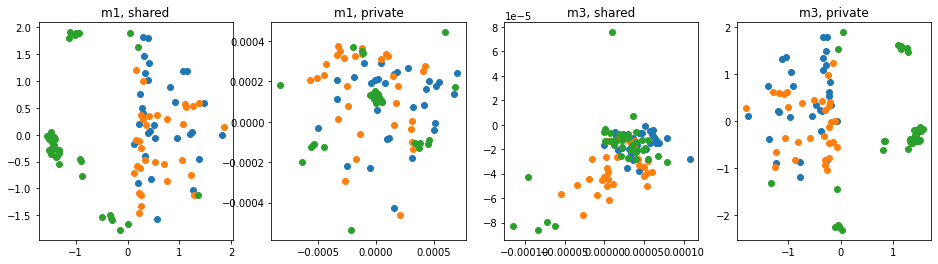

In [26]:
Xs_mean1 = m1.Xs_mean.numpy()
Xp_mean1 = m1.Xp_mean.numpy()
top_idx_s1 = np.argsort(1 / m1.kernel_s.lengthscales.numpy())[-2:]
top_idx_k1 = np.argsort(1 / m1.kernel_K[0].lengthscales.numpy())[-2:]
Xs_mean3 = m3.Xs_mean.numpy()
Xp_mean3 = m3.Xp_mean.numpy()
top_idx_s3 = np.argsort(1 / m3.kernel_s.lengthscales.numpy())[-2:]
top_idx_k3 = np.argsort(1 / m3.kernel_K[0].lengthscales.numpy())[-2:]

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs = axs.flatten()

for i in np.unique(labels):
    axs[0].scatter(Xs_mean1[labels == i, top_idx_s1[-1]], Xs_mean1[labels == i, top_idx_s1[-2]], label=i)
    axs[0].set_title("m1, shared")
    axs[1].scatter(Xp_mean1[labels == i, top_idx_k1[-1]], Xp_mean1[labels == i, top_idx_k1[-2]], label=i)
    axs[1].set_title("m1, private")
    axs[2].scatter(Xs_mean3[labels == i, top_idx_s3[-1]], Xs_mean3[labels == i, top_idx_s3[-2]], label=i)
    axs[2].set_title("m3, shared")
    axs[3].scatter(Xp_mean3[labels == i, top_idx_k3[-1]], Xp_mean3[labels == i, top_idx_k3[-2]], label=i)
    axs[3].set_title("m3, private")

## Prior to 09/15

#### Experiment 3
* Setting
    * K = 3, Qs = Qp = 5, M = 20
    * Xs_mean = Xp_mean = PCA(1:5)
    * Zs, Zp are separate permutation of respective X mean
* Result
    * ELBO stable at around -290 after ~8700 iterations, each iteration took 0.08s
    * Everything gets assigned to one category.
    * In the shared space, similar overfitting problem as Exp 2: really large lengthscale, small Xs
    * In the private space where everything gets assigned, learn some relevant dimensions and some separations in those dimensions, but worse than Exp 2, very similar to Exp 4

Text(0, 0.5, 'ELBO')

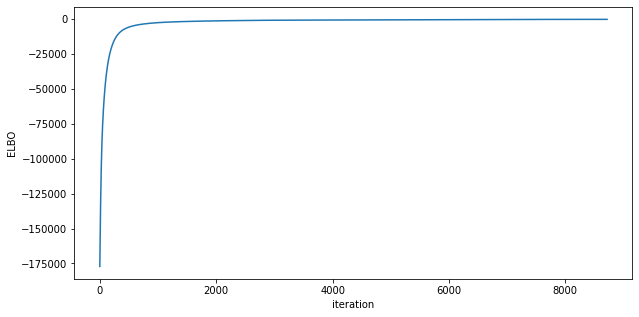

In [346]:
plt.figure(figsize=(10, 5))
plt.plot(logf[1:])
plt.xlabel('iteration')
plt.ylabel('ELBO')

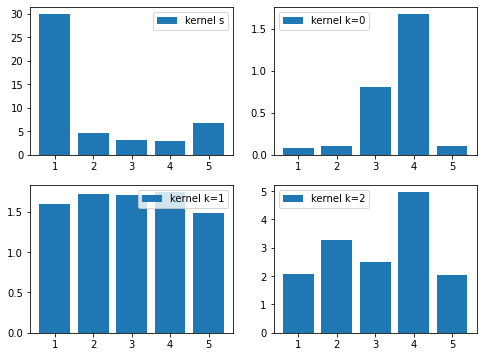

In [347]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6)) 
axs = axs.flatten()

axs[0].bar(np.arange(1, 6), 1 / split_gplvm.kernel_s.lengthscales.numpy(), label='kernel s')
axs[0].legend()

axs[1].bar(np.arange(1, 6), 1 / split_gplvm.kernel_K[0].lengthscales.numpy(), label='kernel k=0')
axs[1].legend()

axs[2].bar(np.arange(1, 6), 1 / split_gplvm.kernel_K[1].lengthscales.numpy(), label='kernel k=1')
axs[2].legend()

axs[3].bar(np.arange(1, 6), 1 / split_gplvm.kernel_K[2].lengthscales.numpy(), label='kernel k=2')
axs[3].legend()

plt.legend()

In [348]:
assignments = split_gplvm.pi.numpy().argmax(axis=1)

In [349]:
assignments

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

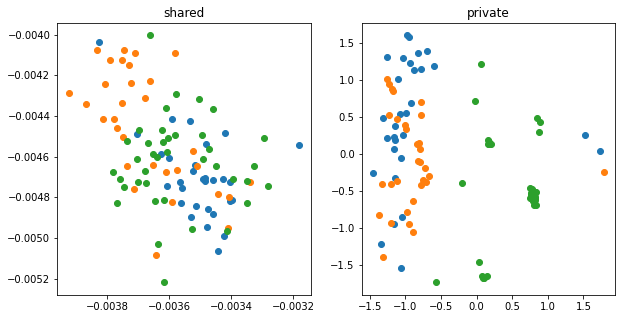

In [350]:
Xs_mean = split_gplvm.Xs_mean.numpy()
Xp_mean = split_gplvm.Xp_mean.numpy()
top_idx_s = np.argsort(1 / split_gplvm.kernel_s.lengthscales.numpy())[-2:]
top_idx_k = np.argsort(1 / split_gplvm.kernel_K[0].lengthscales.numpy())[-2:]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

for i in np.unique(labels):
    axs[0].scatter(Xs_mean[labels == i, top_idx_s[-1]], Xs_mean[labels == i, top_idx_s[-2]], label=i)
    axs[0].set_title("shared")
    axs[1].scatter(Xp_mean[labels == i, top_idx_k[-1]], Xp_mean[labels == i, top_idx_k[-2]], label=i)
    axs[1].set_title("private")

#### Experiment 4
* Setting
    * Same setting as Exp 3, except K = 1, M = 20, Zs and Zp are initialized to be the same as test gplvm (Zs takes dim 1-5, Zp takes dim 6-10)
    * Should be the same as Exp 2
    * Optimize w/ Adam
* Result
    * Converge around ELBO = -70
    * Still overfit in the shared space, but less severe
    * Some separation in private space, but worse than the equivalent Exp 2 (Why?)

Text(0, 0.5, 'ELBO')

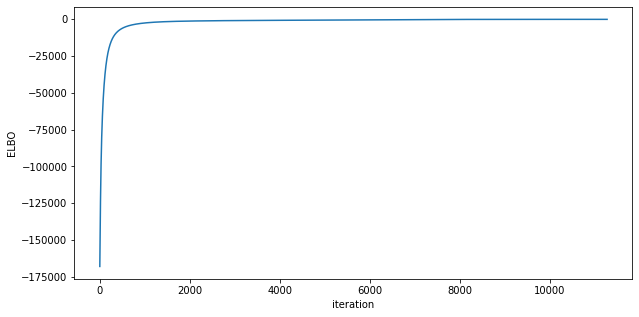

In [328]:
plt.figure(figsize=(10, 5))
plt.plot(logf[1:])
plt.xlabel('iteration')
plt.ylabel('ELBO')

Text(0, 0.5, 'inverse lengthscale')

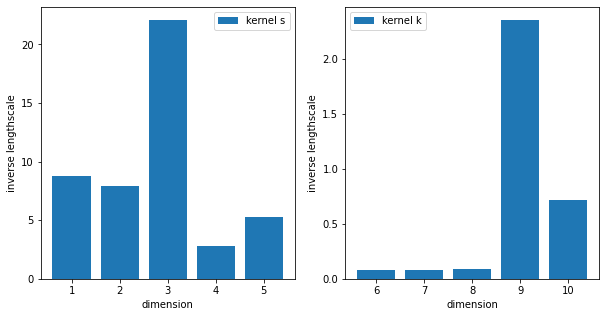

In [330]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 
axs = axs.flatten()

axs[0].bar(np.arange(1, 6), 1 / split_gplvm.kernel_s.lengthscales.numpy(), label='kernel s')
axs[0].legend()
axs[0].set_xlabel('dimension')
axs[0].set_ylabel('inverse lengthscale')

axs[1].bar(np.arange(6, 11), 1 / split_gplvm.kernel_K[0].lengthscales.numpy(), label='kernel k')
axs[1].legend()
axs[1].set_xlabel('dimension')
axs[1].set_ylabel('inverse lengthscale')

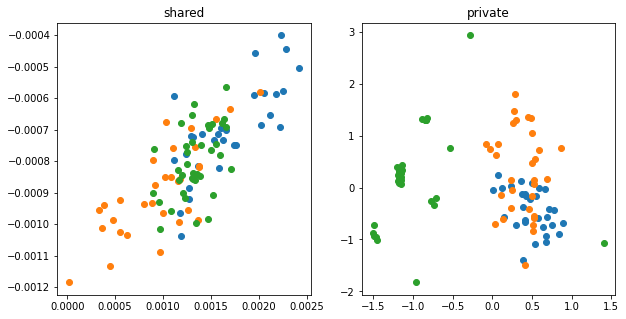

In [331]:
Xs_mean = split_gplvm.Xs_mean.numpy()
Xp_mean = split_gplvm.Xp_mean.numpy()
top_idx_s = np.argsort(1 / split_gplvm.kernel_s.lengthscales.numpy())[-2:]
top_idx_k = np.argsort(1 / split_gplvm.kernel_K[0].lengthscales.numpy())[-2:]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

for i in np.unique(labels):
    axs[0].scatter(Xs_mean[labels == i, top_idx_s[-1]], Xs_mean[labels == i, top_idx_s[-2]], label=i)
    axs[0].set_title("shared")
    axs[1].scatter(Xp_mean[labels == i, top_idx_k[-1]], Xp_mean[labels == i, top_idx_k[-2]], label=i)
    axs[1].set_title("private")

#### Experiment 5
* Setting
    * Same as 4, except optimize w/ scipy
* Result
    * Terminate w/ cholesky error

In [50]:
split_gplvm

name,class,transform,prior,trainable,shape,dtype,value
SplitGPLVM.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.5716669933768824
SplitGPLVM.kernel_s.variance,Parameter,Softplus,,True,(),float64,6.666279305532761e-44
SplitGPLVM.kernel_s.lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[8.77657980e+00, 5.21726385e+00, 2.68549241e+01..."
SplitGPLVM.kernel_K[0].variance,Parameter,Softplus,,True,(),float64,1.1979879841631141e-62
SplitGPLVM.kernel_K[0].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[38.93034656, 39.0936686, 77.41352583..."
SplitGPLVM.Xs_mean,Parameter,,,True,"(100, 5)",float64,"[[-2.91985738e-09, -4.79116335e-09, 4.67625988e-09..."
SplitGPLVM.Xs_var,Parameter,Softplus,,True,"(100, 5)",float64,"[[0.99999989, 0.99999989, 0.99999989..."
SplitGPLVM.Xp_mean,Parameter,,,True,"(100, 5)",float64,"[[8.71103054e-10, -2.88751202e-09, -4.30191162e-09..."
SplitGPLVM.Xp_var,Parameter,Softplus,,True,"(100, 5)",float64,"[[0.99999988, 0.99999987, 0.99999986..."
SplitGPLVM.pi,Parameter,SoftmaxCentered,,True,"(100, 1)",float64,[[1....


Text(0, 0.5, 'inverse lengthscale')

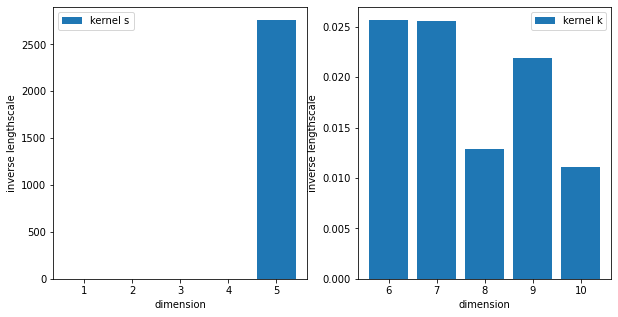

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 
axs = axs.flatten()

axs[0].bar(np.arange(1, 6), 1 / split_gplvm.kernel_s.lengthscales.numpy(), label='kernel s')
axs[0].legend()
axs[0].set_xlabel('dimension')
axs[0].set_ylabel('inverse lengthscale')

axs[1].bar(np.arange(6, 11), 1 / split_gplvm.kernel_K[0].lengthscales.numpy(), label='kernel k')
axs[1].legend()
axs[1].set_xlabel('dimension')
axs[1].set_ylabel('inverse lengthscale')

In [52]:
split_gplvm.kernel_s.lengthscales.numpy()

array([8.77657980e+00, 5.21726385e+00, 2.68549241e+01, 2.43786979e+01,
       3.62250170e-04])

In [53]:
split_gplvm.kernel_K[0].lengthscales.numpy()

array([38.93034656, 39.0936686 , 77.41352583, 45.55478043, 90.09847157])

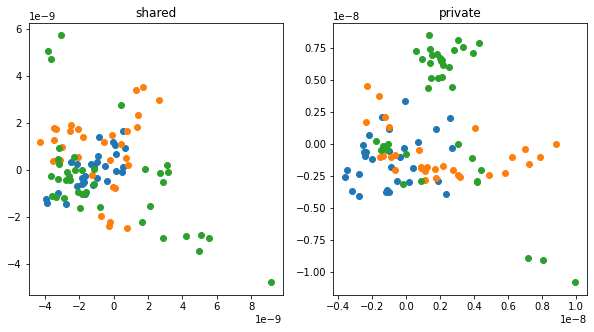

In [54]:
Xs_mean = split_gplvm.Xs_mean.numpy()
Xp_mean = split_gplvm.Xp_mean.numpy()
top_idx_s = np.argsort(1 / split_gplvm.kernel_s.lengthscales.numpy())[-2:]
top_idx_k = np.argsort(1 / split_gplvm.kernel_K[0].lengthscales.numpy())[-2:]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

for i in np.unique(labels):
    axs[0].scatter(Xs_mean[labels == i, top_idx_s[-1]], Xs_mean[labels == i, top_idx_s[-2]], label=i)
    axs[0].set_title("shared")
    axs[1].scatter(Xp_mean[labels == i, top_idx_k[-1]], Xp_mean[labels == i, top_idx_k[-2]], label=i)
    axs[1].set_title("private")

#### Experiment 6
* Setting
    * Same as Exp 3, except we initialize the prior to be the correct assignment
* Result
    * Converge at 10680, elbo=-164

Text(0, 0.5, 'ELBO')

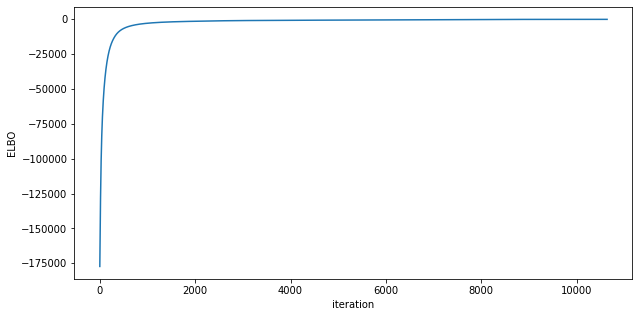

In [443]:
plt.figure(figsize=(10, 5))
plt.plot(logf[1:])
plt.xlabel('iteration')
plt.ylabel('ELBO')

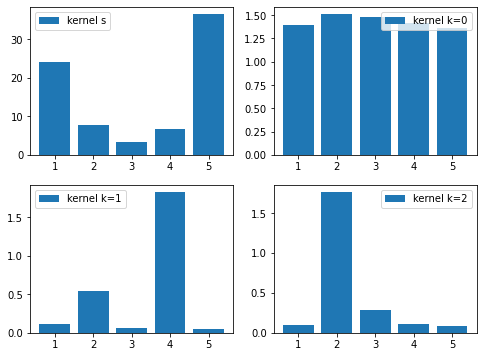

In [444]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6)) 
axs = axs.flatten()

axs[0].bar(np.arange(1, 6), 1 / split_gplvm.kernel_s.lengthscales.numpy(), label='kernel s')
axs[0].legend()

axs[1].bar(np.arange(1, 6), 1 / split_gplvm.kernel_K[0].lengthscales.numpy(), label='kernel k=0')
axs[1].legend()

axs[2].bar(np.arange(1, 6), 1 / split_gplvm.kernel_K[1].lengthscales.numpy(), label='kernel k=1')
axs[2].legend()

axs[3].bar(np.arange(1, 6), 1 / split_gplvm.kernel_K[2].lengthscales.numpy(), label='kernel k=2')
axs[3].legend()

plt.legend()

In [445]:
assignments = split_gplvm.pi.numpy().argmax(axis=1)

In [446]:
assignments

array([1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2,
       1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 2])

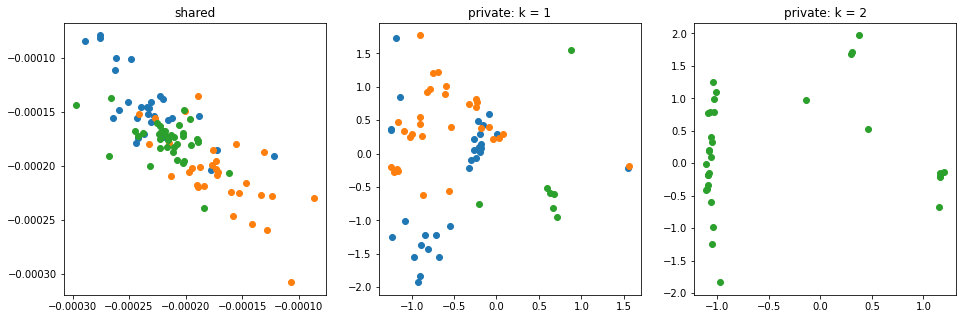

In [452]:
Xs_mean = split_gplvm.Xs_mean.numpy()
Xp_mean = split_gplvm.Xp_mean.numpy()
Xp_mean_k1 = Xp_mean[assignments==1, :]
Xp_mean_k2 = Xp_mean[assignments==2, :]

top_idx_s = np.argsort(1 / split_gplvm.kernel_s.lengthscales.numpy())[-2:]
top_idx_k1 = np.argsort(1 / split_gplvm.kernel_K[1].lengthscales.numpy())[-2:]
top_idx_k2 = np.argsort(1 / split_gplvm.kernel_K[2].lengthscales.numpy())[-2:]

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs = axs.flatten()

for i in np.unique(labels):
    axs[0].scatter(Xs_mean[labels == i, top_idx_s[-1]], 
                   Xs_mean[labels == i, top_idx_s[-2]], label=i)
    axs[0].set_title("shared")
    axs[1].scatter(Xp_mean_k1[labels[assignments==1] == i, top_idx_k1[-1]], 
                   Xp_mean_k1[labels[assignments==1] == i, top_idx_k1[-2]], label=i)
    axs[1].set_title("private: k = 1")
    axs[2].scatter(Xp_mean_k2[labels[assignments==2] == i, top_idx_k2[-1]], 
                   Xp_mean_k2[labels[assignments==2] == i, top_idx_k2[-2]], label=i)
    axs[2].set_title("private: k = 2")